Tutorial to generate random walks in Bitcoin/USD and Ethereum/USD prices that reflects ETH/USD's correlation to BTC/USD movements.

This can be used to generate random walks for multiple series with various correlations for purposes such as:
- Performance of any price asset corelated to any other asset or metric
- MarketCap (or MarketCap/TVL ratio) correlated to any metric such as BTC price, revenue, NFT trading volume, etc
- TVL in the protocol correlated to any metric
- Percentage of ciculating supply staked correlated to any metric
- Daily usage or trading volumes correlated to any metric

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import brownian_motion_generator as bmg

import matplotlib.pyplot as plt

In [2]:
#Fetch market prices
def coin_gecko_prices(coin, against='usd', days=1460):
    url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart?vs_currency={against}&days={days}'.format(coin,against,days) 
    r = requests.get(url)
    df = pd.DataFrame(r.json()['prices'],columns=['unix',f'{coin}_{against}'])
    return df
    

In [3]:
btc = coin_gecko_prices('bitcoin')
eth = coin_gecko_prices('ethereum')
df = pd.merge(btc,eth,how='left',on='unix').dropna(how='any')
df

,unix,bitcoin_usd,ethereum_usd
0,1539561600000,6328.554760,196.318698
1,1539648000000,6659.875508,212.203069
2,1539734400000,6635.125668,212.444287
3,1539820800000,6635.741832,211.082693
4,1539907200000,6517.511088,204.313049
...,...,...,...
1455,1665273600000,19418.037989,1315.857800
1456,1665360000000,19448.149002,1322.269755
1457,1665446400000,19142.694767,1291.081660
1458,1665532800000,19058.628040,1279.883308


In [4]:
#Series should be mean stationary. So in this case of price series, convert them to log normal returns

df['btc_ln_return'] = np.log(df['bitcoin_usd'] / df['bitcoin_usd'].shift(1))
df['eth_ln_return'] = np.log(df['ethereum_usd'] / df['ethereum_usd'].shift(1))
df = df.dropna(how='any')
df

,unix,bitcoin_usd,ethereum_usd,btc_ln_return,eth_ln_return
1,1539648000000,6659.875508,212.203069,0.051029,0.077804
2,1539734400000,6635.125668,212.444287,-0.003723,0.001136
3,1539820800000,6635.741832,211.082693,0.000093,-0.006430
4,1539907200000,6517.511088,204.313049,-0.017978,-0.032597
5,1539993600000,6483.827769,203.976263,-0.005182,-0.001650
...,...,...,...,...,...
1455,1665273600000,19418.037989,1315.857800,-0.002020,-0.006844
1456,1665360000000,19448.149002,1322.269755,0.001549,0.004861
1457,1665446400000,19142.694767,1291.081660,-0.015831,-0.023869
1458,1665532800000,19058.628040,1279.883308,-0.004401,-0.008711


In [5]:
#Approximate the distribution parameters of each series
#Here we will use a custom distribution for each: other options include 'normal' or 'laplace'

OU_params_btc = bmg.estimate_OU_params(df['btc_ln_return'].values, distribution_type='custom')
OU_params_eth = bmg.estimate_OU_params(df['eth_ln_return'].values, distribution_type='custom')

In [22]:
# OPTIONALLY: override the gamma (long term mean) of the expected distribution
#For example if you wanted to ignore the historical trend in prices, and force price changes to be 0 mean
# OU_params_btc.gamma = 0
# OU_params_eth.gamma = 0

In [6]:
T = 90 # number of steps for each simulation. Here simulating next 90 trading days
OU_params = (
    OU_params_btc,
    OU_params_eth,
)
num_sims = 1_000 # number of simulations to run. Here generating 1,000 different random walks
correlations = df[
    ['btc_ln_return',
     'eth_ln_return',
    ]
].corr().values[0]

In [7]:
OU_procs = bmg.simulate_corr_OU_procs(T, OU_params, num_sims, rho=correlations)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1478.05it/s]


In [8]:
#Turn the numpy array of (num_sims, T, num_procs) shape into a dataframe
sims,steps,procs = OU_procs.shape
OU_procs_arr = np.column_stack((np.repeat(np.arange(sims),steps),OU_procs.reshape(sims*steps,-1)))
sims = pd.DataFrame(OU_procs_arr,
                     columns=[
                         'simulation',
                         'btc_ln_return',
                         'eth_ln_return',
                     ])



In [9]:
#We now have num_sim random walks of T steps for each column
#In this case we are dealing with daily returns
#If we want to visualize the cumulative path, need to aggregate daily changes into cumultative changes

sims['step'] = sims.groupby('simulation').cumcount() + 1

sims['cumulative_btc_ln_return'] = np.exp(sims.groupby('simulation')['btc_ln_return'].transform('cumsum'))
sims['cumulative_eth_ln_return'] = np.exp(sims.groupby('simulation')['eth_ln_return'].transform('cumsum'))

sims['btc_index'] = sims['cumulative_btc_ln_return'] * 100 # index to 100 starting value
sims['eth_index'] = sims['cumulative_eth_ln_return'] * 100 # index to 100 starting value


In [10]:
#Our random walks are ready to use for risk analsysis, scenario testing, and Monte Carlos!

#Bonus Section: Visualizing last steps and given walks

In [11]:
#Check the distribution of cumulative price movements in our simulations
final_steps = sims.drop_duplicates('simulation',keep='last')
final_steps[['btc_index','eth_index']].describe()

,btc_index,eth_index
count,1000.000000,1000.000000
mean,109.643090,118.116120
std,26.973774,37.787974
min,48.144281,43.798506
25%,89.565052,90.953014
50%,106.533001,112.895662
75%,125.816676,140.620627
max,263.642888,293.786940


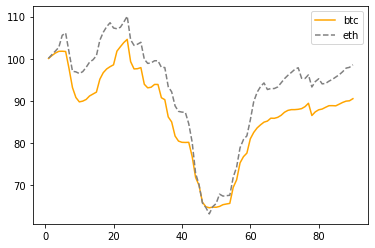

In [19]:
#Chart any given simulation's random walk
simulation = 0
data = sims[sims['simulation'] == simulation]
step = data['step']
btc = data['btc_index']
eth = data['eth_index']

plt.plot(step, btc, label = "btc", color='orange', linestyle="-")
plt.plot(step, eth, label = "eth", color='gray', linestyle="--")
plt.legend()
plt.show()

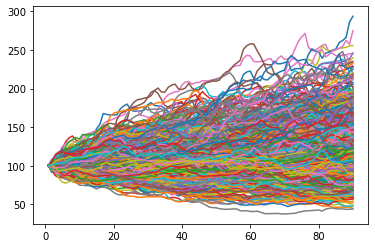

In [20]:
#Chart all simulations for a given series
for simulation in range(0,num_sims):
    data = sims[sims['simulation'] == simulation]

    step = data['step']
    index = data['eth_index']

    plt.plot(step, index, linestyle="-")
    
plt.show()